# 집값 예측 MLP

In [131]:
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim # model , optimizer
from torch.utils.data import DataLoader, Dataset # Dataset, DataLoader
import torch.nn.functional as F # activation Function
import matplotlib.pyplot as plt


In [132]:
df = pd.read_csv('data/reg.csv',index_col=[0])
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.028702,0.019528,0.455716,0.097575,0.576859,0.588769,0.654701,0.188444,0.007595,0.165409,0.736795,0.982923,0.219891,0.386667
502,0.034217,0.009498,0.490485,0.372934,0.532351,0.580505,0.750547,0.143776,0.051186,0.166428,0.867950,0.995114,0.207453,0.346667
503,0.035352,0.021495,0.423918,0.397988,0.349407,0.610529,0.907637,0.087385,0.083448,0.164870,0.782704,0.995791,0.094044,0.420000
504,0.026182,0.028603,0.443442,0.509663,0.229142,0.667841,0.867135,0.236241,0.016177,0.167554,0.749186,0.986855,0.107399,0.377778


In [133]:
x = df.drop('Price',axis = 1).to_numpy()
x.shape

(506, 13)

In [149]:
y = df['Price'].to_numpy()
y = y.reshape(-1,1)
 # y데이터셋에 마지막 1차원을 추가해 주는 이유는 훈련데이터를 모델에 넣어 얻은 값의 
 # 차원과(32,1) 정답데이터의 차원(32,1)이 같아야하기 때문!!
 # 만약 차원을 추가해 주지 않으면 정답데이터의 차원은 (32,)이기때문에 
 # 자동으로 broad casting되어 올바르지 못한 학습이 진행되게 된다. 
y.shape

(506, 1)

In [150]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = 0.3)

In [151]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(354, 13)
(152, 13)
(354, 1)
(152, 1)


In [152]:
# Dataset 과 DataLoader 만들기 

class DS(Dataset):
    def __init__(self,x,y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        self.len = self.y.shape[0]
       

    def __getitem__(self,index):
        return self.x[index],self.y[index]

    def __len__(self):
        return self.len

In [153]:
trainsets = DS(train_x,train_y)
testsets = DS(test_x,test_y)
trainloader = DataLoader(trainsets,batch_size = 32, shuffle=False)
testloader = DataLoader(testsets,batch_size= 32, shuffle=False)

In [154]:
# 모델 구축 

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,1)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x



In [155]:
model = Regressor()
lr = 1e-3
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),0.001,weight_decay=1e-7)


In [156]:
loss_ = [] 
n = len(trainloader)
for i in range(400):
    running_loss = 0
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        y_hat = model(inputs)
        loss = criterion(y_hat,values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_.append(running_loss/n)

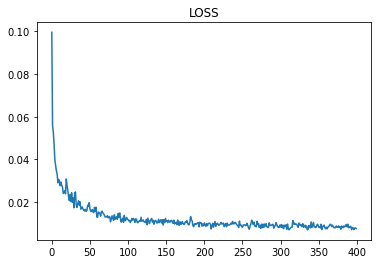

In [157]:
plt.plot(loss_)
plt.title("LOSS")
plt.show()

In [158]:
from sklearn.metrics import mean_squared_error

In [159]:
def Eval(dl):
    predictions = torch.tensor([],dtype = float)
    actual = torch.tensor([],dtype = torch.float)
    with torch.no_grad():
        model.eval()
        for data in dl:
            inputs,values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions,outputs),0)
            actual = torch.cat((actual,values),0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions,actual))
    
    return rmse


In [160]:
train_rmse = Eval(trainloader)
test_rmse = Eval(testloader)
print('train rmse: ', train_rmse)
print('test rmse: ', test_rmse)

train rmse:  0.0745199873949921
test rmse:  0.11605187982702506
